In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('/Users/pradeep/exp/capstone/data/Fine_2014_2019_Finger_millet_Min_Blore_Mysore.csv')
df1.head()

,district,commodity,Arrival Date,variety,Min_price
0,Mysore,Ragi (Finger Millet),02-01-14,Fine,1600
1,Mysore,Ragi (Finger Millet),03-01-14,Fine,2000
2,Mysore,Ragi (Finger Millet),04-01-14,Fine,1800
3,Mysore,Ragi (Finger Millet),07-01-14,Fine,2000
4,Mysore,Ragi (Finger Millet),08-01-14,Fine,2100


In [3]:
gp = pd.pivot_table(df1,values='Min_price',columns=['district','commodity'],index=['Arrival Date'])


In [4]:
flattened = pd.DataFrame(gp.to_records())
flattened['Arrival Date'] = pd.to_datetime(flattened['Arrival Date'],format ='%d-%m-%y')
flattened = flattened.sort_values(by=['Arrival Date'])
df = flattened.reset_index()
del df['index']

df = df.set_index('Arrival Date').asfreq('D')
df = df.fillna(method='ffill')
df.head()

,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
Arrival Date,,
2014-01-02,1600.0,1600.0
2014-01-03,2000.0,2000.0
2014-01-04,1800.0,1800.0
2014-01-05,1800.0,1800.0
2014-01-06,1800.0,1800.0


In [5]:
df.to_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv', encoding='utf-8')

In [6]:
df = pd.read_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv')

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]), <a list of 10 Text xticklabel objects>)

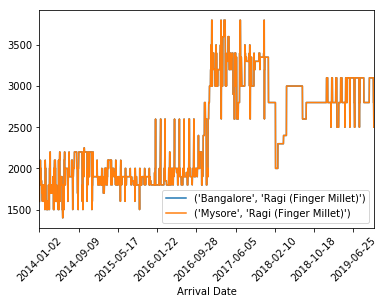

In [7]:
df.plot(x='Arrival Date')
plt.xticks(x='Arrival Date',rotation=45)

In [8]:
df['Arrival Date'] = pd.to_datetime(df['Arrival Date']).astype('int')
df.describe()

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
count,2.135000e+03,2135.000000,2135.000000
mean,1.480810e+18,2445.550351,2445.550351
std,5.326264e+16,585.045889,585.045889
min,1.388621e+18,1400.000000,1400.000000
25%,1.434715e+18,1900.000000,1900.000000
50%,1.480810e+18,2300.000000,2300.000000
75%,1.526904e+18,3000.000000,3000.000000
max,1.572998e+18,3800.000000,3800.000000


In [9]:
training_set = df.iloc[:,[1,2]].values
training_set

array([[1600., 1600.],
       [2000., 2000.],
       [1800., 1800.],
       ...,
       [2800., 2800.],
       [2800., 2800.],
       [3100., 3100.]])

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(training_set)

In [11]:
train_size = int(len(scaled) * 0.75)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 1601
test: 534


In [12]:
print(train.shape)
print(test.shape)

(1601, 2)
(534, 2)


In [13]:
train

array([[0.08333333, 0.08333333],
       [0.25      , 0.25      ],
       [0.16666667, 0.16666667],
       ...,
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667]])

In [14]:
def create_dataset(dataset, look_back=32):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        b = dataset[i + look_back]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1601 16
534 16


In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1584, 16, 2)
(517, 16, 2)
(1584, 2)
(517, 2)


In [17]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2] ))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print(X_train.shape)
print(X_test.shape)

(1584, 16, 2)
(517, 16, 2)


In [18]:
batch_size = 1
model = Sequential()
model.add(LSTM(units=400, batch_input_shape=(batch_size, look_back, 2), stateful=True))

model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

W0124 23:24:53.640924 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0124 23:24:53.656623 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0124 23:24:53.659546 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0124 23:24:54.054327 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 400)                  644800    
_________________________________________________________________
dense_1 (Dense)              (1, 2)                    802       
Total params: 645,602
Trainable params: 645,602
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

W0124 23:24:54.243093 140735499449152 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0124 23:24:54.568588 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0124 23:24:54.672777 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
 - 28s - loss: 0.0059
Epoch 2/20
 - 27s - loss: 0.0048
Epoch 3/20
 - 33s - loss: 0.0047
Epoch 4/20
 - 27s - loss: 0.0042
Epoch 5/20
 - 26s - loss: 0.0041
Epoch 6/20
 - 26s - loss: 0.0040
Epoch 7/20
 - 33s - loss: 0.0040
Epoch 8/20
 - 26s - loss: 0.0039
Epoch 9/20
 - 26s - loss: 0.0039
Epoch 10/20
 - 26s - loss: 0.0038
Epoch 11/20
 - 26s - loss: 0.0038
Epoch 12/20
 - 26s - loss: 0.0039
Epoch 13/20
 - 28s - loss: 0.0037
Epoch 14/20
 - 32s - loss: 0.0038
Epoch 15/20
 - 27s - loss: 0.0038
Epoch 16/20
 - 26s - loss: 0.0037
Epoch 17/20
 - 26s - loss: 0.0037
Epoch 18/20
 - 26s - loss: 0.0037
Epoch 19/20
 - 30s - loss: 0.0037
Epoch 20/20
 - 35s - loss: 0.0036


In [20]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [21]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 133.16 MSE
Test Score column 0: 244.26 MSE
Train Score column 1: 1474.35 MSE
Test Score column 1: 545.39 MSE


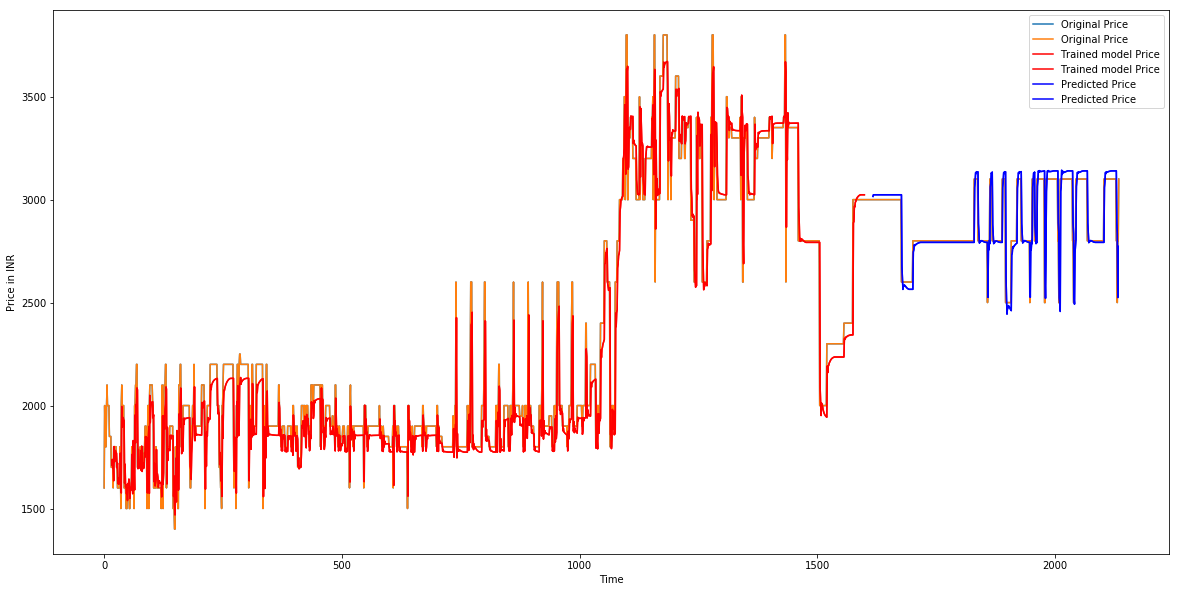

In [22]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Trained model Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()

In [23]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1601 16
534 16


In [24]:
## Stacked LSTM
#batch_size = 1
modelst = Sequential()
modelst.add(LSTM(units=400, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
#model.add(LSTM(50, return_sequences=True))  
modelst.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
modelst.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
modelst.add(LSTM(units=200, batch_input_shape=(batch_size, look_back, 2), stateful=True))
modelst.add(Dense(2))
modelst.compile(loss='mean_squared_error', optimizer='adam')
modelst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 16, 400)              644800    
_________________________________________________________________
lstm_3 (LSTM)                (1, 16, 100)              200400    
_________________________________________________________________
lstm_4 (LSTM)                (1, 16, 100)              80400     
_________________________________________________________________
lstm_5 (LSTM)                (1, 200)                  240800    
_________________________________________________________________
dense_2 (Dense)              (1, 2)                    402       
Total params: 1,166,802
Trainable params: 1,166,802
Non-trainable params: 0
_________________________________________________________________


In [25]:
modelst.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 123s - loss: 0.0137
Epoch 2/20
 - 108s - loss: 0.0063
Epoch 3/20
 - 89s - loss: 0.0053
Epoch 4/20
 - 85s - loss: 0.0049
Epoch 5/20
 - 85s - loss: 0.0049
Epoch 6/20
 - 85s - loss: 0.0049
Epoch 7/20
 - 85s - loss: 0.0047
Epoch 8/20
 - 83s - loss: 0.0044
Epoch 9/20
 - 82s - loss: 0.0064
Epoch 10/20
 - 82s - loss: 0.0043
Epoch 11/20
 - 86s - loss: 0.0044
Epoch 12/20
 - 81s - loss: 0.0045
Epoch 13/20
 - 86s - loss: 0.0043
Epoch 14/20
 - 83s - loss: 0.0041
Epoch 15/20
 - 83s - loss: 0.0042
Epoch 16/20
 - 85s - loss: 0.0042
Epoch 17/20
 - 84s - loss: 0.0040
Epoch 18/20
 - 91s - loss: 0.0040
Epoch 19/20
 - 98s - loss: 0.0040
Epoch 20/20
 - 82s - loss: 0.0040


In [26]:
trainPredict = modelst.predict(X_train, batch_size=batch_size)
modelst.reset_states()

testPredict = modelst.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 2157.06 MSE
Test Score column 0: 1889.71 MSE
Train Score column 1: 4560.76 MSE
Test Score column 1: 2194.09 MSE


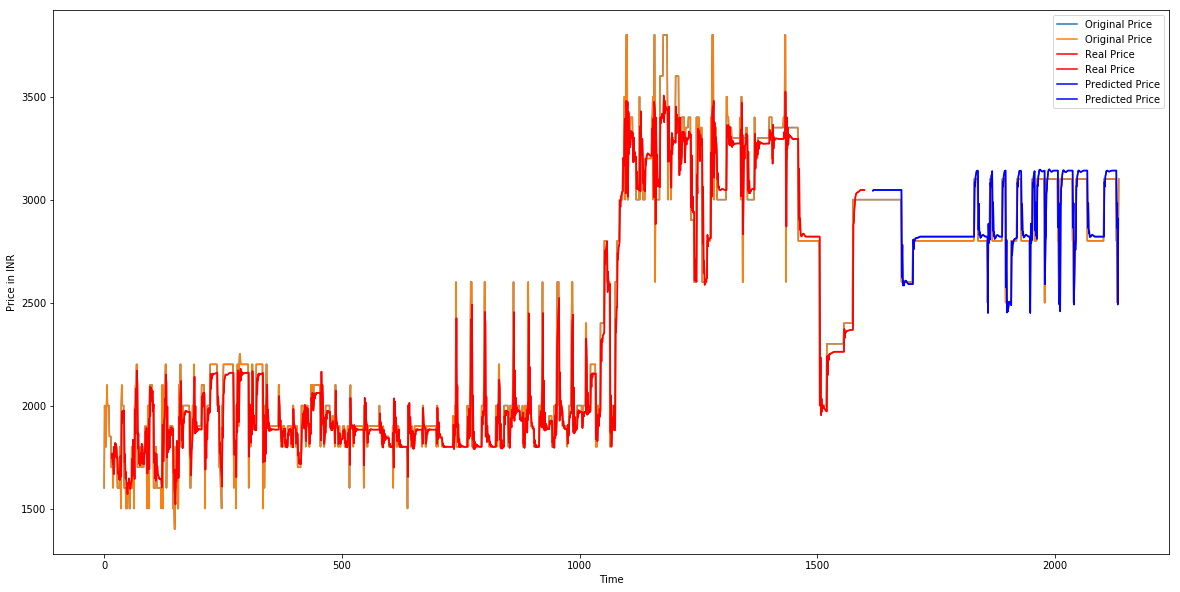

In [27]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Real Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()

In [28]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1601 16
534 16


In [29]:
## GRU
batch_size = 1
modelg = Sequential()
modelg.add(GRU(units=200, batch_input_shape=(batch_size, look_back, 2), stateful=True))
#model.add(LSTM(50, return_sequences=True))  
#model.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 1), stateful=True))

modelg.add(Dense(2))
modelg.compile(loss='mean_squared_error', optimizer='adam')
modelg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 200)                  121800    
_________________________________________________________________
dense_3 (Dense)              (1, 2)                    402       
Total params: 122,202
Trainable params: 122,202
Non-trainable params: 0
_________________________________________________________________


In [30]:
modelg.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 21s - loss: 0.0052
Epoch 2/20
 - 23s - loss: 0.0043
Epoch 3/20
 - 22s - loss: 0.0043
Epoch 4/20
 - 18s - loss: 0.0042
Epoch 5/20
 - 20s - loss: 0.0041
Epoch 6/20
 - 26s - loss: 0.0039
Epoch 7/20
 - 15s - loss: 0.0039
Epoch 8/20
 - 14s - loss: 0.0040
Epoch 9/20
 - 14s - loss: 0.0039
Epoch 10/20
 - 14s - loss: 0.0039
Epoch 11/20
 - 14s - loss: 0.0039
Epoch 12/20
 - 14s - loss: 0.0038
Epoch 13/20
 - 15s - loss: 0.0038
Epoch 14/20
 - 15s - loss: 0.0038
Epoch 15/20
 - 15s - loss: 0.0038
Epoch 16/20
 - 15s - loss: 0.0038
Epoch 17/20
 - 15s - loss: 0.0037
Epoch 18/20
 - 15s - loss: 0.0038
Epoch 19/20
 - 15s - loss: 0.0038
Epoch 20/20
 - 17s - loss: 0.0037


In [31]:
trainPredict = modelg.predict(X_train, batch_size=batch_size)
modelg.reset_states()

testPredict = modelg.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 10314.45 MSE
Test Score column 0: 4654.80 MSE
Train Score column 1: 9223.78 MSE
Test Score column 1: 4673.67 MSE


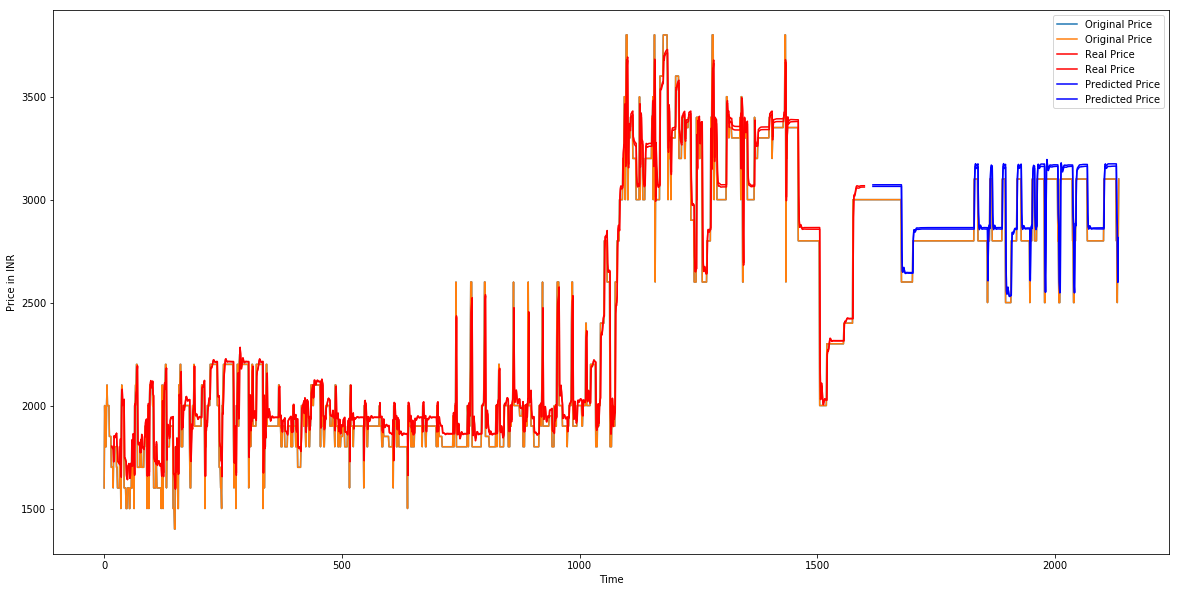

In [32]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Real Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()